## Financial Stability Index (FSI) project

#### ---------- SETUP & LIBRARIES ----------

In [29]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from scipy.stats import zscore

In [30]:
!pip install reportlab

In [40]:
# ---------- USER CONFIG ----------
DATA_DIR = r"D:\\Project 0.1"  # Your folder location
os.makedirs(DATA_DIR, exist_ok=True)

In [41]:
file_path = DATA_DIR + r"\RBI_Data.xlsx"
df = pd.read_excel(file_path)
df.head(5)

,Month,Demand Deposits,Time Deposits,Aggregate deposits (2+3),Aggregate deposits (2+3) (Adjusted),Borrowings from RBI,Liabilities to Banks,Other demand and time liabilities,Investments in Govt. securities,Investments in other approved securities,...,Cash in hand,Balances with RBI,Assets with Banks,Liquidity,Deposit Stability Growth,Deposit Stability,CD Ratio,Investment/Deposit Ratio,Market Risk Volatility,Market Risk - Coefficient of Variation
0,1,2.000,3.00,4.00,5,6,7.0000,8.000000e+00,9.000,10.000000,...,17.00000,18.00,19.0000,2.000000e+01,21.000000,22.000000,23.000000,24.000000,25.000000,26.000000
1,2025-07-25 00:00:00,2876367.982,20473459.01,23349826.99,-,1906,469955.1494,9.896720e+05,6726283.636,544.014774,...,82474.89212,918229.35,369221.3423,8.096209e+06,0.324706,14.049253,79.235607,28.808897,0.930421,-111.563856
2,2025-06-27 00:00:00,3072874.359,20352770.98,23425645.34,23373018.82,1065,496493.4438,1.046816e+06,6696347.538,454.342774,...,86670.83355,933483.32,398514.3646,8.115016e+06,-1.080451,15.098064,78.914367,28.587481,0.951853,-117.489878
3,2025-05-30 00:00:00,2988920.703,20183621.92,23172542.62,23117503.01,6516,500763.7895,1.034574e+06,6706168.846,548.394974,...,87179.07024,956086.24,403817.2651,8.153251e+06,-1.345030,14.808644,78.918301,28.942518,0.969433,-117.603742
4,2025-04-18 00:00:00,2638562.427,20222302.44,22860864.87,22802332.51,24763,475577.8688,1.015129e+06,6692826.967,615.812974,...,81710.65781,909268.82,372053.3323,8.055860e+06,-1.225954,13.047784,79.559070,29.279044,0.969094,-118.703680


In [49]:
def load_rbi_data(path='RBI_Data.xlsx', date_col='Month'):
    """
    Load RBI_Data.xlsx, parse Month column in the format '25-Jul-2025',
    and return a clean time-series dataframe.
    """

    # Load Excel file
    df = pd.read_excel(path)

    # Convert '25-Jul-2025' to datetime
    df[date_col] = pd.to_datetime(df[date_col], format='%d-%b-%Y', errors='coerce')

    # Set datetime index
    df = df.set_index(date_col).sort_index()

    return df

try:
    df = load_rbi_data('RBI_Data.xlsx')
    print("RBI data loaded successfully!")
except Exception as e:
    print("Error loading RBI_Data.xlsx:", e)
    df = pd.DataFrame()


RBI data loaded successfully!


In [50]:
df.head(10)


,Demand Deposits,Time Deposits,Aggregate deposits (2+3),Aggregate deposits (2+3) (Adjusted),Borrowings from RBI,Liabilities to Banks,Other demand and time liabilities,Investments in Govt. securities,Investments in other approved securities,Investment In India(8+9),...,Cash in hand,Balances with RBI,Assets with Banks,Liquidity,Deposit Stability Growth,Deposit Stability,CD Ratio,Investment/Deposit Ratio,Market Risk Volatility,Market Risk - Coefficient of Variation
Month,,,,,,,,,,,,,,,,,,,,,
2016-01-22,8.121242e+05,8.406149e+06,9.218273e+06,NaN,161941,228489.87396,452967.64045,2.697553e+06,1863.0875,2.699417e+06,...,61285.64195,380788.0,264063.04407,3.403690e+06,-100.000000,9.661073,76.537950,29.283320,NaN,NaN
2016-02-19,8.403359e+05,8.459073e+06,9.299409e+06,NaN,183945,222504.39840,473409.39365,2.702653e+06,1825.4680,2.704479e+06,...,57507.89178,387106.0,265606.81340,3.412874e+06,-0.872487,9.934137,76.830454,29.082265,NaN,NaN
2016-03-18,8.889962e+05,8.438294e+06,9.327290e+06,NaN,232467,225025.96707,504039.96156,2.623933e+06,1575.7410,2.625509e+06,...,57438.48369,387442.0,260399.10669,3.329213e+06,-0.298914,10.535260,77.724773,28.148677,70.093737,-138.974936
2016-04-29,9.037633e+05,8.621561e+06,9.525324e+06,NaN,88650,225997.56391,480662.47967,2.691026e+06,1546.0106,2.692572e+06,...,62072.64310,398272.0,257335.18364,3.408706e+06,-2.079030,10.482595,75.927017,28.267515,57.397589,-170.199054
2016-05-27,8.755754e+05,8.638511e+06,9.514087e+06,NaN,95740,215328.38496,479563.10239,2.730556e+06,1612.8726,2.732169e+06,...,63880.90080,383948.0,248960.54769,3.427345e+06,0.118116,10.135721,75.955178,28.717089,49.463825,-191.626611
2016-06-24,8.847108e+05,8.658812e+06,9.543522e+06,NaN,82743,211312.57244,481562.03031,2.744580e+06,1683.8941,2.746263e+06,...,61905.36403,394021.0,238777.64774,3.439284e+06,-0.308437,10.217463,75.736819,28.776203,44.378858,-215.154958
2016-07-22,8.671846e+05,8.754722e+06,9.621907e+06,NaN,29968,214225.87465,459808.23611,2.791197e+06,1864.2787,2.793062e+06,...,64712.60401,386742.0,234922.58305,3.477574e+06,-0.814646,9.905336,75.250651,29.028150,40.551080,-235.213372
2016-08-19,8.905535e+05,8.787697e+06,9.678251e+06,NaN,10214,208777.00203,477152.21332,2.808065e+06,1661.2987,2.809726e+06,...,61730.71213,388797.0,223879.09354,3.482471e+06,-0.582167,10.134094,74.886663,29.031340,37.534883,-252.019735
2016-09-30,1.042784e+06,9.050862e+06,1.009365e+07,NaN,34367,223728.91833,458150.40463,2.855398e+06,1432.6835,2.856830e+06,...,61950.08191,412406.0,260676.58331,3.590430e+06,-4.115420,11.521379,74.253327,28.303253,35.116989,-267.972560


In [56]:
df_test = pd.read_excel("RBI_Data.xlsx")
print(df_test.columns.tolist())

['Month', 'Demand Deposits', 'Time Deposits', 'Aggregate deposits (2+3)', 'Aggregate deposits (2+3) (Adjusted)', 'Borrowings from RBI', 'Liabilities to Banks', 'Other demand and time liabilities', 'Investments in Govt. securities', 'Investments in other approved securities', 'Investment In India(8+9)', 'Investment In India(8+9) (Adjusted)', 'Food credit', 'Non - Food credit', 'Bank Credit (11+12)', 'Bank Credit (11+12) (Adjusted)', 'Cash in hand', 'Balances with RBI', 'Assets with Banks', 'Liquidity', 'Deposit Stability Growth', 'Deposit Stability', 'CD Ratio', 'Investment/Deposit Ratio', 'Market Risk Volatility', 'Market Risk - Coefficient of Variation']


In [57]:
# ---------- MERGE STEP (UPDATED FOR SINGLE RBI DATASET) ----------

# Since all indicators are already in ONE dataset (df),
# we simply rename it to df_all for consistency with the FSI pipeline.

df_all = df

print("\nFinal dataset shape:", df_all.shape)
df_all.head()


Final dataset shape: (121, 25)


,Demand Deposits,Time Deposits,Aggregate deposits (2+3),Aggregate deposits (2+3) (Adjusted),Borrowings from RBI,Liabilities to Banks,Other demand and time liabilities,Investments in Govt. securities,Investments in other approved securities,Investment In India(8+9),...,Cash in hand,Balances with RBI,Assets with Banks,Liquidity,Deposit Stability Growth,Deposit Stability,CD Ratio,Investment/Deposit Ratio,Market Risk Volatility,Market Risk - Coefficient of Variation
Month,,,,,,,,,,,,,,,,,,,,,
2016-01-22,812124.19998,8.406149e+06,9.218273e+06,NaN,161941,228489.87396,452967.64045,2.697553e+06,1863.0875,2.699417e+06,...,61285.64195,380788.0,264063.04407,3.403690e+06,-100.000000,9.661073,76.537950,29.283320,NaN,NaN
2016-02-19,840335.91595,8.459073e+06,9.299409e+06,NaN,183945,222504.39840,473409.39365,2.702653e+06,1825.4680,2.704479e+06,...,57507.89178,387106.0,265606.81340,3.412874e+06,-0.872487,9.934137,76.830454,29.082265,NaN,NaN
2016-03-18,888996.18412,8.438294e+06,9.327290e+06,NaN,232467,225025.96707,504039.96156,2.623933e+06,1575.7410,2.625509e+06,...,57438.48369,387442.0,260399.10669,3.329213e+06,-0.298914,10.535260,77.724773,28.148677,70.093737,-138.974936
2016-04-29,903763.30371,8.621561e+06,9.525324e+06,NaN,88650,225997.56391,480662.47967,2.691026e+06,1546.0106,2.692572e+06,...,62072.64310,398272.0,257335.18364,3.408706e+06,-2.079030,10.482595,75.927017,28.267515,57.397589,-170.199054
2016-05-27,875575.41922,8.638511e+06,9.514087e+06,NaN,95740,215328.38496,479563.10239,2.730556e+06,1612.8726,2.732169e+06,...,63880.90080,383948.0,248960.54769,3.427345e+06,0.118116,10.135721,75.955178,28.717089,49.463825,-191.626611


In [61]:
# ---------- FIX NON-NUMERIC VALUES FIRST ----------
df_all = df_all.replace(['-', ' ', ''], np.nan)

# Convert all columns to numeric (errors='coerce' will turn text into NaN)
df_all = df_all.apply(pd.to_numeric, errors='coerce')

print("After converting to numeric:")
print(df_all.dtypes)


After converting to numeric:
Demand Deposits                             float64
Time Deposits                               float64
Aggregate deposits (2+3)                    float64
Aggregate deposits (2+3) (Adjusted)         float64
Borrowings from RBI                         float64
Liabilities to Banks                        float64
Other demand and time liabilities           float64
Investments in Govt. securities             float64
Investments in other approved securities    float64
Investment In India(8+9)                    float64
Investment In India(8+9) (Adjusted)         float64
Food credit                                 float64
Non - Food credit                           float64
Bank Credit (11+12)                         float64
Bank Credit (11+12) (Adjusted)              float64
Cash in hand                                float64
Balances with RBI                           float64
Assets with Banks                           float64
Liquidity                          

In [64]:
# ---------- DATA CLEANING (UPDATED FOR SINGLE RBI DATASET) ----------

# 1) Impute missing values (median)
imputer = SimpleImputer(strategy='median')
df_clean = pd.DataFrame(
    imputer.fit_transform(df_all),
    index=df_all.index,
    columns=df_all.columns
)

# 2) Handle outliers using Winsorization via z-score
zscores = df_clean.apply(zscore).abs()
extreme = (zscores > 4)

if extreme.any().any():
    df_clean = df_clean.clip(
        lower=df_clean.quantile(0.01),
        upper=df_clean.quantile(0.99),
        axis=1
    )

# 3) Inspect
print('\nCleaned data head:')
print(df_clean.head())



Cleaned data head:
            Demand Deposits  Time Deposits  Aggregate deposits (2+3)  \
Month                                                                  
2016-01-22    817766.543174   8.412578e+06              9.234500e+06   
2016-02-19    840335.915950   8.459073e+06              9.299409e+06   
2016-03-18    888996.184120   8.438294e+06              9.327290e+06   
2016-04-29    903763.303710   8.621561e+06              9.525324e+06   
2016-05-27    875575.419220   8.638511e+06              9.514087e+06   

            Aggregate deposits (2+3) (Adjusted)  Borrowings from RBI  \
Month                                                                  
2016-01-22                          21110366.61             161941.0   
2016-02-19                          21110366.61             183945.0   
2016-03-18                          21110366.61             232467.0   
2016-04-29                          21110366.61              88650.0   
2016-05-27                          2111036

In [69]:
# ---------- DEFINE OUTPUT DIRECTORY ----------
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# ---------- EXPORT CLEAN LIQUIDITY INDICATORS FOR POWER BI ----------

liquidity_cols = [
    'Liquidity',
    'Deposit Stability',
    'Deposit Stability Growth',
    'CD Ratio',
    'Investment/Deposit Ratio'
]

# Keep only columns that actually exist
liquidity_cols = [c for c in liquidity_cols if c in df_clean.columns]

# Create liquidity indicators dataframe
liquidity_indicators_clean = df_clean[liquidity_cols].copy()

# Save to outputs folder
liquidity_indicators_clean.to_csv(
    os.path.join(output_dir, 'liquidity_indicators_clean.csv'),
    index=False
)

print("liquidity_indicators_clean.csv successfully created!")


liquidity_indicators_clean.csv successfully created!


In [70]:
# ---------- NORMALIZATION & DIRECTIONALITY (UPDATED FOR YOUR RBI DATASET) ----------

# In your dataset, all indicators behave as:
# Higher value → Higher liquidity or financial level (not "good-bad" indicators)
# So nothing needs to be inverted.

def transform_direction(df, invert_cols=[]):
    df2 = df.copy()
    for col in invert_cols:
        if col in df2.columns:
            df2[col] = -df2[col]
    return df2

# For your dataset — no financial ratios like CAR/ROA exist:
suggested_invert = []
print("\nSuggested invert columns:", suggested_invert)

# Apply direction transformation
df_dir = transform_direction(df_clean, invert_cols=suggested_invert)

# -------- Standardization (Z-score normalization) --------
scaler = StandardScaler()
df_std = pd.DataFrame(
    scaler.fit_transform(df_dir),
    index=df_dir.index,
    columns=df_dir.columns
)

print("\nStandardized data (first 5 rows):")
print(df_std.head())



Suggested invert columns: []

Standardized data (first 5 rows):
            Demand Deposits  Time Deposits  Aggregate deposits (2+3)  \
Month                                                                  
2016-01-22        -1.552676      -1.400146                 -1.421568   
2016-02-19        -1.512150      -1.386715                 -1.405403   
2016-03-18        -1.424775      -1.392717                 -1.398460   
2016-04-29        -1.398258      -1.339777                 -1.349144   
2016-05-27        -1.448873      -1.334880                 -1.351942   

            Aggregate deposits (2+3) (Adjusted)  Borrowings from RBI  \
Month                                                                  
2016-01-22                             0.057781             0.728866   
2016-02-19                             0.057781             0.993985   
2016-03-18                             0.057781             1.578612   
2016-04-29                             0.057781            -0.154194  

In [71]:
# ---------- INDEX CONSTRUCTION (UPDATED FOR YOUR RBI DATASET) ----------

# Since your dataset only contains liquidity/balance sheet indicators,
# we create a single dimension: "Liquidity"

dimensions = {
    'Liquidity': df_std.columns.tolist()  # all columns belong to liquidity dimension
}

print('\nDetected dimension columns:')
for k, v in dimensions.items():
    print(k, ':', v)

# ---------- Aggregate each dimension ----------
dimension_series = pd.DataFrame(index=df_std.index)

for dim, cols in dimensions.items():
    if cols:
        dimension_series[dim] = df_std[cols].mean(axis=1)
    else:
        dimension_series[dim] = np.nan

print('\nDimension series head:')
print(dimension_series.head())

# ---------- Assign weights ----------
# Only one dimension, so weight = 1
weights = {'Liquidity': 1.0}

# ---------- Compute Financial Stress Index ----------
fsi = pd.Series(0, index=dimension_series.index, dtype=float)

for dim, w in weights.items():
    fsi += w * dimension_series[dim]

# Normalize index
fsi = (fsi - fsi.mean()) / fsi.std()

# ---------- Export to CSV ----------
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

fsi.to_csv(os.path.join(output_dir, 'financial_stability_index.csv'), header=['FSI'])

pd.concat([dimension_series, fsi.rename('FSI')], axis=1).to_csv(
    os.path.join(output_dir, 'fsi_with_dimensions.csv')
)

print('\nFSI saved to outputs/financial_stability_index.csv')



Detected dimension columns:
Liquidity : ['Demand Deposits', 'Time Deposits', 'Aggregate deposits (2+3)', 'Aggregate deposits (2+3) (Adjusted)', 'Borrowings from RBI', 'Liabilities to Banks', 'Other demand and time liabilities', 'Investments in Govt. securities', 'Investments in other approved securities', 'Investment In India(8+9)', 'Investment In India(8+9) (Adjusted)', 'Food credit', 'Non - Food credit', 'Bank Credit (11+12)', 'Bank Credit (11+12) (Adjusted)', 'Cash in hand', 'Balances with RBI', 'Assets with Banks', 'Liquidity', 'Deposit Stability Growth', 'Deposit Stability', 'CD Ratio', 'Investment/Deposit Ratio', 'Market Risk Volatility', 'Market Risk - Coefficient of Variation']

Dimension series head:
            Liquidity
Month                
2016-01-22  -0.789986
2016-02-19  -0.632445
2016-03-18  -0.352305
2016-04-29  -0.497814
2016-05-27  -0.444805

FSI saved to outputs/financial_stability_index.csv


In [72]:
# ---------- PCA-BASED LIQUIDITY STRESS INDEX ----------

from sklearn.decomposition import PCA

# Ensure only numeric liquidity columns are used
df_pca_input = df_std.select_dtypes(include='number')

# Apply PCA (1 principal component = Liquidity Stress Index)
pca = PCA(n_components=1)
pca_values = pca.fit_transform(df_pca_input.fillna(0))

# Create Liquidity Stress Index series
liquidity_stress_index = pd.Series(
    pca_values.flatten(),
    index=df_pca_input.index,
    name='Liquidity_Stress_Index'
)

# Normalize for interpretation (z-score)
liquidity_stress_index = (
    liquidity_stress_index - liquidity_stress_index.mean()
) / liquidity_stress_index.std()

# Save output
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

liquidity_stress_index.to_csv(
    os.path.join(output_dir, 'liquidity_stress_index_pca.csv')
)

print("Liquidity Stress Index (PCA-based) saved successfully.")
print("Explained variance by PC1:", round(pca.explained_variance_ratio_[0], 3))


Liquidity Stress Index (PCA-based) saved successfully.
Explained variance by PC1: 0.55


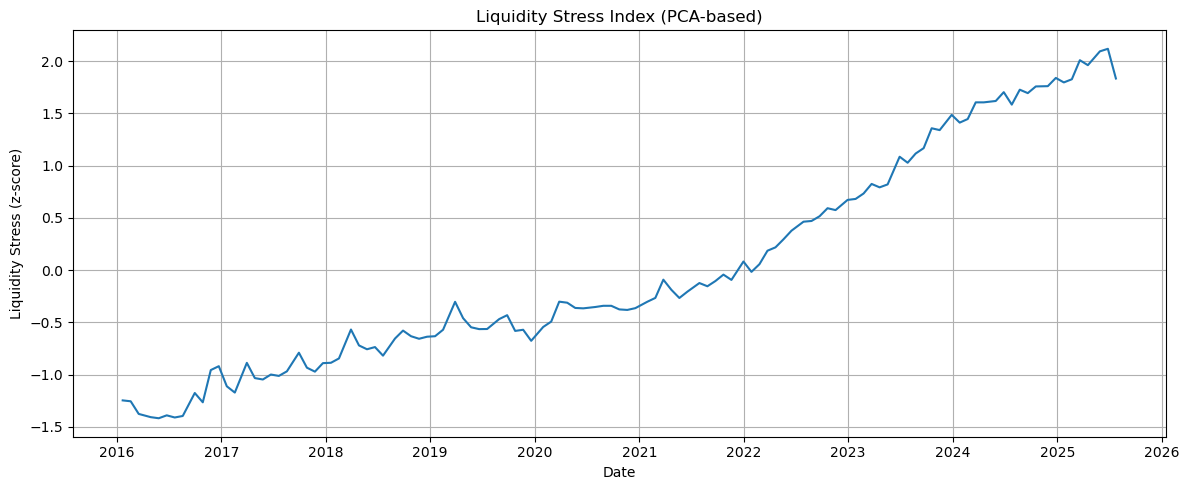

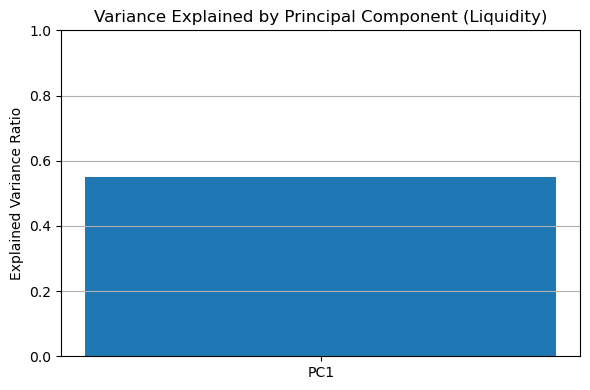

In [73]:
# ---------- VISUALIZATIONS (UPDATED: LIQUIDITY PCA ONLY) ----------

plt.figure(figsize=(12,5))
plt.plot(liquidity_stress_index.index, liquidity_stress_index.values)
plt.title('Liquidity Stress Index (PCA-based)')
plt.ylabel('Liquidity Stress (z-score)')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'liquidity_stress_index_timeseries.png'))
plt.show()


# ---------- PCA EXPLAINED VARIANCE ----------

plt.figure(figsize=(6,4))
plt.bar(['PC1'], pca.explained_variance_ratio_)
plt.title('Variance Explained by Principal Component (Liquidity)')
plt.ylabel('Explained Variance Ratio')
plt.ylim(0,1)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'pca_explained_variance.png'))
plt.show()


In [74]:
from statsmodels.tsa.stattools import adfuller

def check_adf(series, signif=0.05):
    """
    Run Augmented Dickey-Fuller test to check stationarity
    """
    result = adfuller(series.dropna())
    return {
        'adf_statistic': result[0],
        'p_value': result[1],
        'used_lag': result[2],
        'n_observations': result[3],
        'stationary': result[1] < signif
    }


In [75]:
# ---------- STATISTICAL CHECKS & ROBUSTNESS (UPDATED) ----------

# 1️⃣ ADF Test on Liquidity Stress Index (Stationarity Check)
adf_res = check_adf(liquidity_stress_index)
print('\nADF Test on Liquidity Stress Index:')
print(adf_res)


# 2️⃣ PCA Loadings (Contribution of Each Liquidity Indicator)
pca_loadings = pd.Series(
    pca.components_[0],
    index=df_std.columns
).sort_values(ascending=False)

print('\nPCA Loadings (Indicator Contributions):')
print(pca_loadings)


# 3️⃣ Rolling Mean & Volatility (Structural Stress Detection)
rolling_mean = liquidity_stress_index.rolling(window=12).mean()
rolling_std = liquidity_stress_index.rolling(window=12).std()

print('\nRolling statistics computed (12-period window).')



ADF Test on Liquidity Stress Index:
{'adf_statistic': -1.679885394099082, 'p_value': 0.44150478393066656, 'used_lag': 1, 'n_observations': 119, 'stationary': False}

PCA Loadings (Indicator Contributions):
Non - Food credit                           0.268355
Bank Credit (11+12)                         0.268255
Liquidity                                   0.267017
Aggregate deposits (2+3)                    0.266848
Time Deposits                               0.266842
Investment In India(8+9)                    0.265199
Investments in Govt. securities             0.265199
Demand Deposits                             0.264226
Other demand and time liabilities           0.262709
Balances with RBI                           0.258283
Liabilities to Banks                        0.245432
Deposit Stability                           0.192639
Assets with Banks                           0.191706
CD Ratio                                    0.161712
Cash in hand                                0.14081

In [76]:
# ---------- EXPORT: REPORT & ARTIFACTS (UPDATED: LIQUIDITY PCA ONLY) ----------
# This block exports:
# 1) CSVs for Power BI
# 2) PNG plots
# 3) A short research-style PDF summary


# OPTIONAL: Quick PDF summary using reportlab
# (Run: pip install reportlab  — only once, if not installed)

try:
    from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
    from reportlab.lib.styles import getSampleStyleSheet

    pdf_path = os.path.join(output_dir, 'Liquidity_Stress_Index_Report.pdf')

    doc = SimpleDocTemplate(pdf_path)
    styles = getSampleStyleSheet()
    story = []

    # ---------- Title ----------
    story.append(
        Paragraph(
            'Liquidity Stress Index for Indian Banking System (PCA-Based)',
            styles['Title']
        )
    )
    story.append(Spacer(1, 12))

    # ---------- Description ----------
    story.append(
        Paragraph(
            """
            This report presents a Liquidity Stress Index constructed using
            Reserve Bank of India (RBI) banking liquidity indicators.
            Principal Component Analysis (PCA) is applied to extract the
            dominant liquidity stress signal over time.
            """,
            styles['BodyText']
        )
    )
    story.append(Spacer(1, 12))

    # ---------- Main Time Series Plot ----------
    story.append(
        Image(
            os.path.join(output_dir, 'liquidity_stress_index_timeseries.png'),
            width=480,
            height=240
        )
    )
    story.append(Spacer(1, 12))

    # ---------- PCA Explained Variance ----------
    story.append(
        Image(
            os.path.join(output_dir, 'pca_explained_variance.png'),
            width=360,
            height=240
        )
    )

    doc.build(story)

    print('\nPDF summary created successfully at:', pdf_path)

except Exception as e:
    print(
        '\nPDF creation failed. Either reportlab is not installed '
        'or an error occurred.\nError:', e
    )



PDF summary created successfully at: outputs\Liquidity_Stress_Index_Report.pdf


In [78]:
df_clean.columns

Index(['Demand Deposits', 'Time Deposits', 'Aggregate deposits (2+3)',
       'Aggregate deposits (2+3) (Adjusted)', 'Borrowings from RBI',
       'Liabilities to Banks', 'Other demand and time liabilities',
       'Investments in Govt. securities',
       'Investments in other approved securities', 'Investment In India(8+9)',
       'Investment In India(8+9) (Adjusted)', 'Food credit',
       'Non - Food credit', 'Bank Credit (11+12)',
       'Bank Credit (11+12) (Adjusted)', 'Cash in hand', 'Balances with RBI',
       'Assets with Banks', 'Liquidity', 'Deposit Stability Growth',
       'Deposit Stability', 'CD Ratio', 'Investment/Deposit Ratio',
       'Market Risk Volatility', 'Market Risk - Coefficient of Variation'],
      dtype='object')